In [10]:
# find over 1000 job web pages with "Qualifications:"  in them.  
# find the average salary for them, the company name, the job title, and descriptions of
# the qualifications for the job.  
from selenium import webdriver
from bs4 import BeautifulSoup
import urllib
from time import sleep
from readability.readability import Document
import re
import random
import pandas as pd
indeedurlbase = "https://www.indeed.com/jobs?q=data+analyst+%2455%2C000&l=Washington+DC&radius=100&start="
url_list = []
company_list = []
job_titles_list =[]
ave_salary_list =[]
location_list = []
qualifications_list = []
fed_job = 'fccid=bbb'
faa_job = 'fccid=5b02'
page = 1
web_pages = []

# function to find the average salary for the listing being looked at. 
def average_salary(html):
    m = html.find_all('span',{'class':'mat'})
    p = m[1].find('a',href = True)
#    print p['href']
    salary_url = 'https://www.indeed.com'+ p['href']
    driver = webdriver.Chrome()
    driver.get(salary_url)
    html_salary = driver.page_source
    html_salary = BeautifulSoup(html_salary)
    try:
        x = html_salary.find('span',{'class':"salary"}).text
        return x
    except:
        return "No Data"


#this function uses regex to help return a cleaned up web page.
def striphtml(data):
   p = re.compile(r'<.*?>')
   return p.sub('', data)

# this function along with the striphtml() function determines if 
# the string "Qualifications:" is in the web page passed to it. 
def q_check(url):
    try:
        test_html = urllib.urlopen(url).read()
        readable = Document(test_html)
        readable_article = readable.summary()
        strip = striphtml(readable_article)
        x = strip.find("Qualifications:")
        job_text = strip
        return x , job_text  #if "Qualifications:" is in the text of the web page where it is located is returned
    except:
        x = -1
        job_text = ""
        return x, job_text
    
def find_end_word(job_text,company):  #find the end word for searching
    company_words = company.split()  # find the first word in the company name call it ttt
    ttt = company_words[0]
#    print 'ttt =',ttt
    if ttt == "Booz": return "Booz"
#    print 'hi'
    Q_location = job_text.find('Qualifications:') # find location of "Qualifications:"
    Job_Type_location = job_text.find('Job Type')  #  search for "Job Type"
    if Job_Type_location > Q_location: return "Job Type"
    #  the next line finds the locations of the company name in the job_text
    starts = [match.start() for match in re.finditer(re.escape(ttt), job_text)]
    for x in starts:    #  Step through the locations, if it is located after "Q", use it. 
        if x > Q_location: return ttt   
    return 'none'


def job_words(job_text,company):   # this function is to find the job qualifications words.
    
    search_till_word = find_end_word(job_text, company)
    # use regular expressions to find words used to describe job qualifications
    # search from "Qualifications:" to the end_word. If no end_word is found, 
    # insert the word 'none' for the words and move on.   
    if search_till_word == 'none': return 'none'
#    print search_till_word
#    print job_text
#    putting a variable into a regular expression must be done with special sytax.  
#    the next line of code with the {0}   and the   .format(search_till_word)  inserts the variable 
#    'search_till_word'  into where the {0} is .  
#    http://stackoverflow.com/questions/6930982/how-to-use-a-variable-inside-a-regular-expression
    regex = r"(?<=Qualifications:)(.*?)(?= {0})".format(search_till_word)
#    print regex
    try: 
        matches = re.search(regex,job_text)
        match = matches.group()
        return match
    except:
        return 'none'

#  function to clean the text of '!@#$%^&*()_-+={}[]:;"\'|<>,.?/~`'  
def remove_punc2(text):
    punctuation = '!@#$%^&*()_-+={}[]:;"\'|<>,.?/~`'
    clean_text = ""
    for character in text:
        if character not in punctuation:
            clean_text += character
    return clean_text

#  Start of the loop that goes page-by-page through Indeed.  
for page in range(1,100):     
    page_number_string = str(page*10)
    indeedurl = indeedurlbase + page_number_string  # code to go to the next page on Indeed
    
    driver = webdriver.Chrome()
    driver.get(indeedurl)
# wait a varyng # of seconds
    sleep(float(round(random.uniform(1.5, 4.5),1)))
#grab the page source
    try:
        html = driver.page_source    # I used 'try' because on occasion, it would crash
        html = BeautifulSoup(html)
    except:
        continue
        
#    initialize temporary folders to hold data while I am scraping the current Indeed page
#   that data will be appended to the final lists at the end of each loop.  
    temp_url = []
    temp_company = []
    temp_salary = []
    temp_title = []
    temp_location = []
    temp_qualifications_words = []
    
# on each Indeed page, find all the standard job listings and scrape for information
#  this version of the program pulls, salary, job title, city location and company name.
# The comments on the other lines of code are for further scraping of the job page for 
# each job listing -  Version II 

    for item in html.find_all('div', {'data-tn-component':'organicJob'}):
#        x = item.find('a',href=True)
#        y = 'https://www.indeed.com' + x['href']
#        q_location,job_text = q_check(y) 
#        if q_location == -1: continue   # if "Qualifications:" is not in the page, move on.
        ave_salary = average_salary(item)
#        if ave_salary == 'No Data': continue
        job_title = item.find('a',title=True)
        temp_title.append(job_title['title'])
        temp_salary.append(ave_salary)
#        temp_url.append(y)
        location = (item.find(itemprop = 'addressLocality').text)
        temp_location.append(location)
        company = (item.find(class_='company').text.strip())
        temp_company.append(company)
#        qualifications_words = job_words(job_text,company)
#        cleaned_q_words = remove_punc2(qualifications_words)
#        temp_qualifications_words.append(cleaned_q_words)
#        print href['href']
#            w.append(href['href'])
#    url_list.extend(temp_url)
    company_list.extend(temp_company)
    job_titles_list.extend(temp_title)
    ave_salary_list.extend(temp_salary)
    location_list.extend(temp_location)
#   qualifications_list.extend(temp_qualifications_words)
    print page



#print len(url_list)
print len(company_list)
print len(job_titles_list)
print len(ave_salary_list)
#print len(qualifications_list)
print len(location_list)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97


AttributeError: 'NoneType' object has no attribute 'text'

The loop was suppose to end and 100 but crashed at 97...I'll take it instead of rerunning it and taking another 2 hours of running.  

In [11]:
print len(company_list)
print len(job_titles_list)
print len(ave_salary_list)
#print len(qualifications_list)
print len(location_list)

970
970
970
970


In [122]:
df['Ave_Salary'].median()

91000.0

In [165]:
# create a Pandas data frame with the lists that were generated from the scrapping.  

df = pd.DataFrame( {'Company': company_list, 'Location':location_list, 'Title':job_titles_list,'Ave_Salary':ave_salary_list})
df.head()

,Ave_Salary,Company,Location,Title
0,"$77,000",Booz Allen Hamilton,"Washington, DC",Data Analyst
1,"$96,000",BCT Partners,"Washington, DC",Business-Data Analyst
2,No Data,"Peak Technology Solutions, Inc.","Washington, DC",GIS Data Curation Analyst
3,"$64,000",Legal Services Corporation,"Washington, DC",Research Project Coordinator and Data Analyst
4,"$64,000",Booz Allen Hamilton,"College Park, MD 20740",Human Language Translation Research Analyst


In [166]:
df['Ave_Salary'] = df['Ave_Salary'].str.replace('No Data', '$72,000')
df.head()

,Ave_Salary,Company,Location,Title
0,"$77,000",Booz Allen Hamilton,"Washington, DC",Data Analyst
1,"$96,000",BCT Partners,"Washington, DC",Business-Data Analyst
2,"$72,000","Peak Technology Solutions, Inc.","Washington, DC",GIS Data Curation Analyst
3,"$64,000",Legal Services Corporation,"Washington, DC",Research Project Coordinator and Data Analyst
4,"$64,000",Booz Allen Hamilton,"College Park, MD 20740",Human Language Translation Research Analyst


,Ave_Salary,Company,Location,Title
0,"$77,000",Booz Allen Hamilton,"Washington, DC",Data Analyst
1,"$96,000",BCT Partners,"Washington, DC",Business-Data Analyst
2,NaN,"Peak Technology Solutions, Inc.","Washington, DC",GIS Data Curation Analyst
3,"$64,000",Legal Services Corporation,"Washington, DC",Research Project Coordinator and Data Analyst
4,"$64,000",Booz Allen Hamilton,"College Park, MD 20740",Human Language Translation Research Analyst
5,"$77,000",MAXIMUS,"Washington, DC 20002 (Capitol Hill area)",Data Analyst
6,"$77,000",Common Securitization Solutions,"Bethesda, MD",Data Analyst
7,"$78,000",ICF International,"Fairfax, VA",Data Analyst
8,"$70,000",Adept Solutions,"Washington, DC",Business/ Data Analyst
9,"$96,000","IQlogg, Inc","Washington, DC",Business Analyst


In [73]:
#df = df[df.Ave_Salary != '4']
#df.head()

In [44]:
df_clean.shape

(970, 4)

In [168]:
df['Ave_Salary'].median()

91000.0

In [167]:
# get rid of the $ and the commas in the Ave_salary column and float it so it is a number

df['Ave_Salary'] = df['Ave_Salary'].str.replace('$', '')
df['Ave_Salary'] = df['Ave_Salary'].str.replace(',', '').astype(float)

In [85]:
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = 8,4

In [88]:
df.head()

,Ave_Salary,Company,Location,Title
0,77000.0,Booz Allen Hamilton,"Washington, DC",Data Analyst
1,96000.0,BCT Partners,"Washington, DC",Business-Data Analyst
2,77000.0,"Peak Technology Solutions, Inc.","Washington, DC",GIS Data Curation Analyst
3,64000.0,Legal Services Corporation,"Washington, DC",Research Project Coordinator and Data Analyst
4,64000.0,Booz Allen Hamilton,"College Park, MD 20740",Human Language Translation Research Analyst


<function matplotlib.pyplot.show>

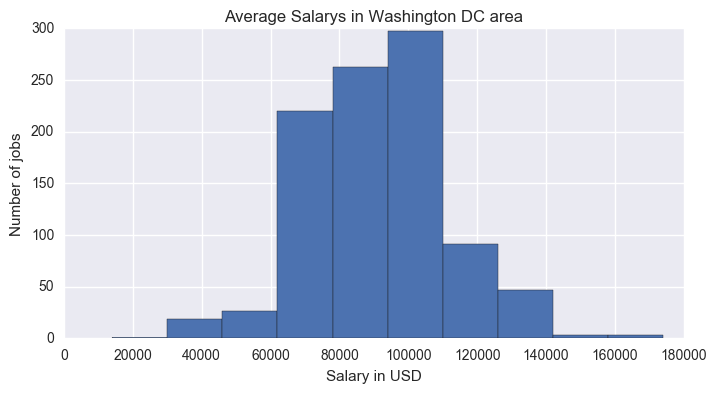

In [117]:
# plot the salary distributions

plt.hist(df['Ave_Salary'])
plt.xlabel("Salary in USD")
plt.title("Average Salarys in Washington DC area")
plt.ylabel("Number of jobs")
plt.savefig('Average Salary.jpg')
plt.show

In [118]:
# create a data frame to generate info about how many jobs are in which cities.  
# Thanks Nathan for your help on this plot.  

df_loc_plot = df.groupby('Location').count()
df_loc_plot = df_loc_plot.reset_index()
df_loc_plot.head(5)

,Location,Ave_Salary,Company,Title,binary_salary
0,"Aberdeen, MD",2,2,2,2
1,"Adelphi, MD",1,1,1,1
2,"Alexandria, VA",32,32,32,32
3,"Alexandria, VA 22311 (Alexandria Wrest area)",6,6,6,6
4,"Alexandria, VA 22314 (Southwest Quadrant area)",7,7,7,7


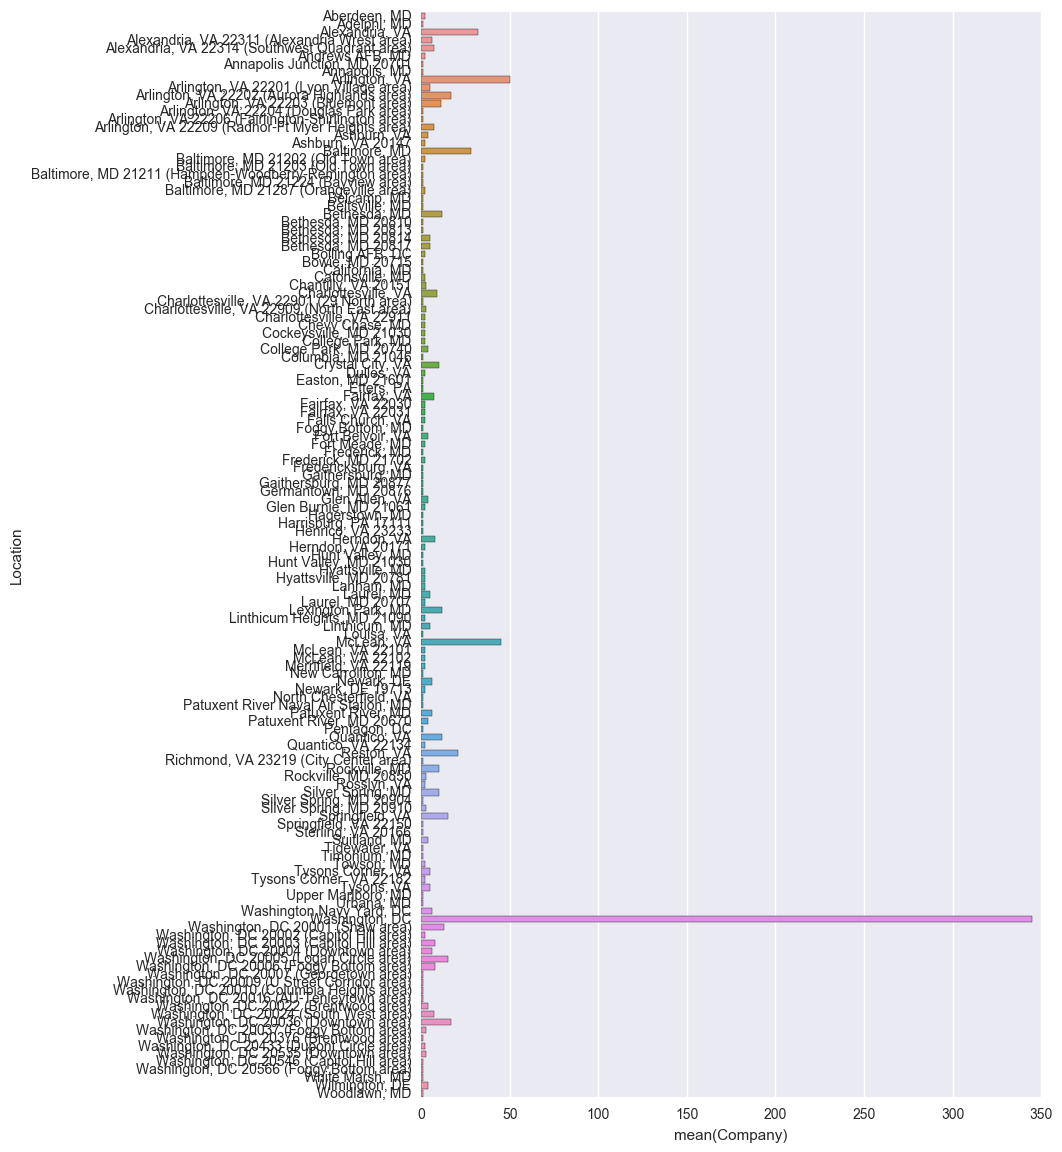

In [119]:
# plot of the number of jobs are in which cities... too much info!
f, ax = plt.subplots(figsize=(8,14))
sns.barplot( x='Company', y='Location',  data=df_loc_plot)

In [139]:
# a function to create a 1 or a 0 for is the salary is over the median or at it and below.
# this will become our target vector.

binary_salary = []
for u in df['Ave_Salary']:
    if u <= df['Ave_Salary'].median():
        binary_salary.append(0)
    else:
        binary_salary.append(1)
            
series = pd.Series(binary_salary)
df['binary_salary'] = series.values
df.head(10)

,Ave_Salary,Company,Location,Title,binary_salary
0,77000.0,Booz Allen Hamilton,"Washington, DC",Data Analyst,0
1,96000.0,BCT Partners,"Washington, DC",Business-Data Analyst,1
2,77000.0,"Peak Technology Solutions, Inc.","Washington, DC",GIS Data Curation Analyst,0
3,64000.0,Legal Services Corporation,"Washington, DC",Research Project Coordinator and Data Analyst,0
4,64000.0,Booz Allen Hamilton,"College Park, MD 20740",Human Language Translation Research Analyst,0
5,77000.0,MAXIMUS,"Washington, DC 20002 (Capitol Hill area)",Data Analyst,0
6,77000.0,Common Securitization Solutions,"Bethesda, MD",Data Analyst,0
7,78000.0,ICF International,"Fairfax, VA",Data Analyst,0
8,70000.0,Adept Solutions,"Washington, DC",Business/ Data Analyst,0
9,96000.0,"IQlogg, Inc","Washington, DC",Business Analyst,1


In [93]:
df.shape

(970, 5)

In [140]:
#  create the X (data frame) and y (series) for the Logistic model approach.

y_df_logistic = df['binary_salary']
#X_df_logistic = df[['Company','Location','Title']]
X_df_logistic = df[['Title','Location']]

In [141]:
# create dummies for the variables Company, Location, Title (drop one from each category and drop the original column) 

#dummies_logistic = pd.get_dummies(X_df_logistic['Company'],drop_first=True)
#X_df_logistic = pd.concat([X_df_logistic, dummies_logistic], axis=1)
#X_df_logistic.drop('Company', axis=1, inplace=True)

dummies_minus_one = pd.get_dummies(X_df_logistic['Location'], drop_first=True)
X_df_logistic = pd.concat([X_df_logistic, dummies_minus_one], axis=1)
X_df_logistic.drop('Location', axis=1, inplace=True)

dummies_minus_one = pd.get_dummies(X_df_logistic['Title'], drop_first=True)
X_df_logistic = pd.concat([X_df_logistic, dummies_minus_one], axis=1)
X_df_logistic.drop('Title', axis=1, inplace=True)

X_df_logistic.head(2)

,"Adelphi, MD","Alexandria, VA","Alexandria, VA 22311 (Alexandria Wrest area)","Alexandria, VA 22314 (Southwest Quadrant area)","Andrews AFB, MD","Annapolis Junction, MD 20701","Annapolis, MD","Arlington, VA","Arlington, VA 22201 (Lyon Village area)","Arlington, VA 22202 (Aurora Highlands area)",...,Urgent Need Tech Requirements Analyst,Vehicle Logistics Analyst - TS REQUIRED,W2 Candidates Only** UAT - Test Analyst,Wargaming Defense Research/Data Analyst (Government),Watch Team Analyst,Watson Health - Sr Research Analyst - Truven,"Yield Analyst, Publisher Platforms",acqusition program analyst,eDiscovery Operations Tech Ops Analyst,mid-level Operations Research Analyst
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
# function to evaluate model inputs

from sklearn.cross_validation import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score

def evaluate_model(model,X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=42)
    instance=model
    instance.fit(X_train,y_train)
    y_pred= instance.predict(X_test)
    
    print accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)
    print classification_report(y_test,y_pred)
    print confusion_matrix(y_test, y_pred)

In [142]:
# run a LogisticRegression model print out the accuracy score.

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=0.1, multi_class = 'ovr', penalty = 'l2')
evaluate_model(model,X_df_logistic,y_df_logistic)


0.635738831615
             precision    recall  f1-score   support

          0       0.63      0.67      0.65       147
          1       0.64      0.60      0.62       144

avg / total       0.64      0.64      0.64       291

[[99 48]
 [58 86]]


In [143]:
#run a RandomForest classification model

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,RandomForestRegressor

model = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
evaluate_model(model,X_df_logistic,y_df_logistic)

0.756013745704
             precision    recall  f1-score   support

          0       0.75      0.77      0.76       147
          1       0.76      0.74      0.75       144

avg / total       0.76      0.76      0.76       291

[[113  34]
 [ 37 107]]


<function matplotlib.pyplot.show>

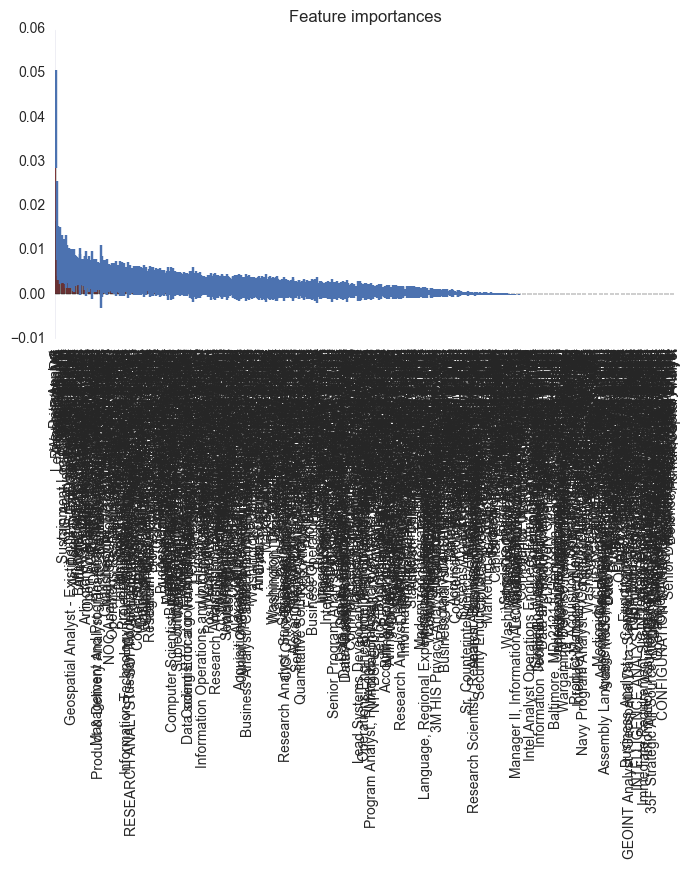

In [144]:
# find the important features from the Random Forest Classifier

all(model.feature_importances_ == np.mean([tree.feature_importances_ for tree in model.estimators_], axis=0))

importances = model.feature_importances_
# calculate the standard deviation of feature importances by looping over the trees in the random forest
# 

std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

indices = np.argsort(importances)[::-1]
feature_names = X_df_logistic.columns

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_df_logistic.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_df_logistic.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_df_logistic.shape[1]])
plt.show

In [103]:
model = RandomForestRegressor( n_jobs=-1)
#evaluate_model(model,X_df_logistic,df['Ave_Salary'])

In [145]:
# print out the important features.

importances = pd.DataFrame((model.feature_importances_ ),
                           index=X_df_logistic.columns,
                           columns=['importance']).sort_values('importance',
                                                                   ascending=False)

importances.head(10)                           

,importance
Data Analyst,0.039607
"Washington, DC",0.016677
Research Analyst,0.009332
"Lexington Park, MD",0.008981
"Springfield, VA",0.008841
Program Analyst,0.008765
"Crystal City, VA",0.008241
"Arlington, VA",0.007956
Analyst,0.007500
Legal Analyst I,0.007499
